<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Profesional III Departamento de Datos no Estructurados  </h1>


#### **Juan Sebastián Gómez Duque**
#### **Estadístico | Científico de datos - Facultad de Ciencias, Universidad Nacional de Colombia**
#### **Correo electrónico: jgomezd@unal.edu.co**

## Clasificación de Imágenes

**Importe de librerías**

Para la primera parte del proceso se importan todas las librerías que serán necesarias en el proceso de clasificación

Se hace uso de las librerías "drive" propias de Google Colaboratory para generar la conexión con mi Google Drive, en el cual he almacenado la información de la base de datos de imagenes que se nos ha suministrado.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Se importan algunas librerías relevantes que posteriormente nos serán de mucha utilidad, estas que se describen a cotinuación principalmente con el objetivo de la manipulación de datos.

In [ ]:
import os # Librería útil para el uso de carpetas del sistema dentro del entorno virtual de Python
import pandas as pd #Librería útil para el manejo de conjuntos de datos y operaciones entre ellos
import copy #Librería útil para crear copias de conjuntos de datos, muy útil para no abusar en la modificación de datos originales
import numpy as np #Librería útil para la operación y cálculo matemático
import matplotlib.pylab as plt #Librería utilizada para el tratamiento de imagenes
import matplotlib.image as mpimg #Librería que posteriormente se utiliza para mostrar una imagen alojada en mi computador

In [ ]:
from sklearn.model_selection import train_test_split # Librería de utilidad para ciencia de datos, usando esta función para la separación de datos
from sklearn import metrics # Función dada para evaluar diferentes metricas y se usará para evaluar el modelo final

Dado que posteriormente haremos uso de esta librería, se instalará inmediatamente la inteligencia artificial de Google "Teseract-OCR" y posteriormente se explicará su uso

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pytesseract #Librería con la capacidad de extraer texto de imagenes 

In [ ]:
!pip install transformers datasets # Librerías necesarias para la carga de herramientas de HugginFace, transformers para modelos y 
                                    #datasets para conjuntos de datos y herramientas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification #Funciones enfocadas a la tokenización que posteriormente tendrán los datos
from transformers import pipeline # Función que abstrae la mayor parte del código complejo de la biblioteca

In [ ]:
from transformers import TrainingArguments, Trainer #Funciones útiles para el re-entrenamiento del modelo 

In [ ]:
from datasets import load_metric # Función utilizada para obtener y generar metricas en modelos de HugginFace

In [ ]:
from transformers import DataCollatorWithPadding # Los recopiladores de datos (o Data Collator) son objetos que formarán un lote utilizando una lista 
                                                    #de elementos del conjunto de datos como entrada

In [ ]:
from transformers import AutoModelForSequenceClassification # Función útil para acceder a modelos clasificatorios de HugginFace

Se instala y carga una versión de torch, compatible con CUDA de Nvidia que se usará para la ejecución de Tesseract-OCR por parte de Google Colaboratory, en conjunto con su GPU virtual

In [ ]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


**Importe del conjunto de datos**

Se procede a seleccionar como carpeta de raiz (en la cual se instalara nuestro proceso) a la carpeta donde se almacenan los Datasets de imagenes suministrados

In [ ]:
os.chdir("../Prueba_conocimientos_davivienda/Ejercicio_1_Imagenes/Datasets")

### 2. Estructure la información

Se lista la información almacenada en la carpeta que inicialmente se eligió para almacenar las carpetas que contienen la información

In [ ]:
os.listdir()

['Documentos',
 'Blanco',
 'diccionario.json',
 'vit-base-beans-demo-v5',
 'train.json',
 'Modificadas',
 'Base.csv']

Se crea la función **base_inicial** que categoriza como 1 a las imagenes que se encuentran en la carpeta "Documentos" y 0 los que se hallan en la carpeta "Blanco"

In [ ]:
def base_incial(nombre):
  aux=[f"{nombre}/"+i for i in os.listdir(nombre)]
  aux=pd.DataFrame(aux).rename(columns={0:'Ruta'})
  if nombre=="Blanco":
    aux["Categoria"]=0
  elif nombre=="Documentos":
    aux["Categoria"]=1

  return aux

Se genera la primera base, que es un DataFrame con la Categoria definida para la ruta de cada imagen

In [ ]:
base=pd.concat([base_incial("Documentos"),base_incial("Blanco")],axis=0)

Vemos como se distribuye y es notorio que hay mayor cantidad de datos dentro de la carpeta de "Blanco"

In [ ]:
base["Categoria"].value_counts()

0    147
1    100
Name: Categoria, dtype: int64

### 3. Describa su Estrategia de Análisis

**Breve descripción del proceso utilizado**

La estrategía de ánalisis utilizada para el proceso de clasificación de imagenes parte de querer convertir este problema que inicialmente presenta un reto de tratamiento y clasificación de imagenes en un reto de procesamiento de lenguaje natural. Estos don los pasos que llevaron a resolver este ejercicio:

1. Se importan los datos a Python (para este caso se hizo uso de Google Colaboratory para dicho proceso)
2. Se unen los datos en un único DataFrame, al cual se le crea una variable llamada "Categoria" que marca 1 en caso que la imagen pertenezca al conjunto de los "Documentos" y 0 si pertenece al conjunto de datos "Blancos"
3. Se hace uso de la herramienta de reconocimiento visual por caracteres "Tesseract-OCR" de Google, la cuál extrae el texto del conjunto de imagenes y lo agrega en un nuevo campo del DataFrame llamado "Texto"
4. Se separa el conjunto de datos original en 3 conjuntos, Entrenamiento (60% del conjunto original), Prueba (20 % del conjunto original) y Validación (20% del conjunto original)
5. Haciendo uso de uno de los transformadores más populares de la plataforma HugginFace, se utiliza el modelo pre-entrenado "DistilBERT Base Uncased" para realizar el proceso de entrenamiento del modelo, realizando este proceso con los conjuntos de datos Entrenamiento y Prueba, que previamente habían sido generados en el paso anterior.
6. Se realiza el proceso de validación del modelo con el último conjunto de datos (Validación), verificando la capacidad de clasificación del modelo y encontrando resultados satisfactorios que llevaron a pensar que éste proceso es el mejor modelo para la clasificación de este conjunto de datos. 

A continuación se muestra un diagrama que permite entender, de manera visual, el proceso que se está realizando para la categorización de imagenes.

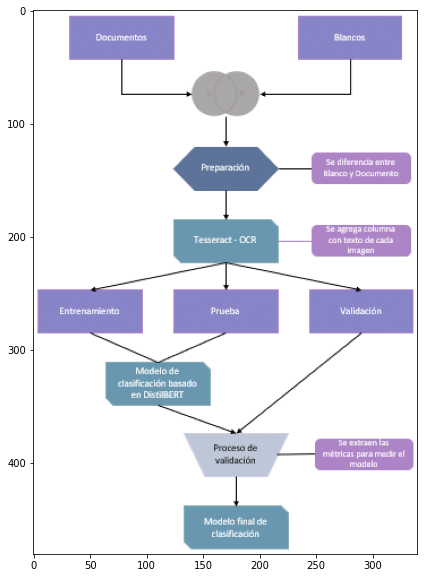

**Uso de Tesseract-OCR y extracción de texto**

Se crea la función **extract_text** que a partir de cada registro en la tabla original (que contiene la ruta de la imagen y su respectiva categoria) extrae el texto de la imagen por medio de la herramienta Tesseract-OCR, haciendo uso del reconocimiento visual de caracteres, y lo agrega a un nuevo campo llamado "Texto". Éste entrega un diccionario con la triada: ruta de la imagen, categoria y texto de la imagen.

In [ ]:
def extract_text(registro):
  filename = registro["Ruta"]
  img1 = np.array(Image.open(filename))
  text = pytesseract.image_to_string(img1)
  return {'Imagen':filename,"Categoria":registro["Categoria"],'Texto':text}

A partir de el conjunto de datos que se generó en un inicio se crea la lista de diccionarios "base" y en esta se guarda un diccionario por cada imagen que originalmente poseíamos.

In [ ]:
base=[extract_text(base.iloc[i]) for i in np.arange(len(base))]

La lista se convierte rápidamente en DataFrame de pandas, esto con el motivo de poder hacer una manipulación de datos más sencilla y separar los datos en diferentes conjuntos para poder alimentar el modelo que usaremos

In [ ]:
base=pd.DataFrame(base)

In [ ]:
base

,Imagen,Categoria,Texto
0,Documentos/page-10.png,1,1. Introduction\n\nComputation has become a ce...
1,Documentos/page-107.png,1,at least one literal is set to TRUE by the ass...
2,Documentos/page-116.png,1,© 2013 — 2018 Advanced Micro Devices Inc. All ...
3,Documentos/page-115.png,1,© 2013 — 2018 Advanced Micro Devices Inc. All ...
4,Documentos/page-11.png,1,method for virtualization. Although Popek and ...
...,...,...,...
242,Blanco/page-289.png,0,
243,Blanco/page-300.png,0,
244,Blanco/page-299.png,0,
245,Blanco/page-302.png,0,


Se guarda el DataFrame (unicamente como garantía por si llega a generar problemas el ambiente online)

In [ ]:
base.to_csv("base_2.csv",index=False)

**Separación de datos para entrenamiento del modelo**

Se genera la separación de datos en Entrenamiento (60% de los datos originales), Prueba (20% de los datos originales) y Validación (20% de los datos originales). Con estos se entrenará el modelo y se realizará una posterior validación para ver el poder de clasificación que pueda tener.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(base["Texto"],base["Categoria"], test_size=0.2, random_state=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

Dado que ya se dio la separación de datos, se realiza una unión para tener en DataFrames separados tanto los datos de entrada como los de salida por cada uno de los conjuntos.

In [ ]:
train=pd.concat([X_train,y_train],axis=1)#60%
test=pd.concat([X_test,y_test],axis=1)#20%
val=pd.concat([X_val,y_val],axis=1)#20#

**Preparación de Dataset's para el re-entrenamiento**

Dado que para el re-entrenamiento del modelo es necesario un formato de conjunto de datos llamado "Dataset" y para construir esta estructura se tiene que dar por medio de conjuntos de diccionarios, se crea la función **crear_diccionarios_texto** que almacena un diccionario para cada imagen que contiene cada uno de estos conjuntos creados (Entrenamiento, Prueba y Validación) 

In [ ]:
def crear_diccionarios_texto(dato):
  return {'label':dato["Categoria"],'text':dato["Texto"]}

Se hace uso de la función y se convierte entonces cada conjunto en una lista de diccionarios

In [ ]:
train=[crear_diccionarios_texto(train.iloc[i,:]) for i in np.arange(len(train))] 
test=[crear_diccionarios_texto(test.iloc[i,:]) for i in np.arange(len(test))] 
val=[crear_diccionarios_texto(val.iloc[i,:]) for i in np.arange(len(val))] 

Se crea, con base en los conjuntos de datos anteriores, diccionarios para los tres grupos (Entrenamiento, Prueba y Validación) en los cuales cada definición se dé por una lista que contenga el texto y la etiqueta corresponidente (la etiqueta se refiere a la categoria que previamente habríamos referido)

In [ ]:
base_train={"text":pd.DataFrame(train)["text"].to_list(),"label":pd.DataFrame(train)["label"].to_list()}
base_test={"text":pd.DataFrame(test)["text"].to_list(),"label":pd.DataFrame(test)["label"].to_list()}
base_val={"text":pd.DataFrame(val)["text"].to_list(),"label":pd.DataFrame(val)["label"].to_list()}

Finalmente, se crean los "Dataset's" con los cuales se alimentará el modelo clasificatorio

In [ ]:
ds_train = Dataset.from_dict(base_train)
ds_test = Dataset.from_dict(base_test)
ds_val = Dataset.from_dict(base_val)

**Ajustes y re-entrenamiento del modelo**

Para el proceso de tokenización de los datos se define el valor máximo de la secuencia de valores a tokenizar

In [ ]:
max_length = 512

Se carga el tokenizador con el transformador "distilbert-base-uncased", uno de los más populares y mejor puntuado modelos de fill-mask en la plataforma HugginFace y se define **tokenize_function** con base en este transformador. Asignando como método para tokenizar "max_lenght" y se define el parametro tal como se definió anteriormente.

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_function(examples):
    return tokenizer(examples["text"],padding='max_length', truncation=True, max_length=max_length)


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.1",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

Se realiza la tokenización para cada conjunto 

In [ ]:
tokenized_datasets_train = ds_train.map(tokenize_function, batched=True) #Datos de Entrenamiento

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets_test = ds_test.map(tokenize_function, batched=True) #Datos de Prueba

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets_val = ds_val.map(tokenize_function, batched=True) #Datos de Validación

  0%|          | 0/1 [00:00<?, ?ba/s]

<img src="https://www.ecured.cu/images/3/31/Matrices_de_confusi%C3%B3n.png" >

Se define la metrica con la cual se realizará la validación del modelo, para el caso se escogió "accuracy", el cual se define como:

$$Accuracy=\frac{VP+VN}{VP+VN+FP+FN}$$

donde:
* VP="Verdaderos positivos"
* VN="Verdaderos negativos"
* FN="Falsos negativos"
* FP="Falsos positivos"

In [ ]:
metric = load_metric("accuracy")

Se define la función **compute_metrics** con la cual se realizará el proceso de validación en cuanto se haya re-entrenado el modelo

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Se definen los argumentos de entrenamiento para el modelo, indicando que se realizará el proceso de almacenamiento de información del entrenamiento en "epochs" y definiendo la carpeta donde se guardará la información que para el caso será "test_trainer"

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Los recopiladores de datos (o Data Collator) son objetos que formarán un lote utilizando una lista de elementos del conjunto de datos como entrada. Aquí definimos el tokenizador que previamente habíamos definido y se solicita que se reciban los valores como tensores.

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

Se define el modelo de clasificación binaria con base en el transformador "distilbert-base-uncased" que ya previamente habíamos utilizado para el tokenizador. Este se descarga de HugginFace y posteriormente lo re-entrenaremos con nuestro conjunto de datos

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

Se definen los paramentros para el re-entrenamiento, utilizando como train_dataset al conjunto de Entrenamiento tokenizado y a eval_dataset al conjunto de Prueba tokenizado, además de los demás prametros que anteriormente ya se habían explicado.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    compute_metrics=compute_metrics,
)

Se realiza el re-entrenamiento y se puede notar un buen proceso de entrenamiento dado que se ajusta bastante bien a los datos, dando un accuracy bastante alto en cada una de las "epochs"

In [ ]:
train_results=trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 147
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.004723,1.000000
2,No log,0.004723,1.000000
3,No log,0.004723,1.000000


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 50
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 50
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 50
  B

Por último, se guardan el modelo, las metricas y el historial de la métrica dentro de la carpeta que previamente se definió. Todo este material se deja adjunto en el GitHub de este proyecto.

In [ ]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to test_trainer
Configuration saved in test_trainer/config.json
Model weights saved in test_trainer/pytorch_model.bin


***** train metrics *****
  epoch                    =        3.0
  total_flos               =    54406GF
  train_loss               =     0.0069
  train_runtime            = 0:00:24.30
  train_samples_per_second =     18.142
  train_steps_per_second   =      2.345


### 4. Interpretación de Reusultados

**Evaluación del modelo**

Se realiza el proceso de evaluación del modelo con los datos de Validación que previamente habíamos tokenizado, así mismo se guarda esta información para llevar un reporte de la construcción del modelo. Dice arrojar un accuracy de 1, sin embargo más adelante probaremos de manera manual que éste proceso esté bien desarrollado.

In [ ]:
metrics_2 = trainer.evaluate(tokenized_datasets_val)
trainer.log_metrics("eval", metrics_2)
trainer.save_metrics("eval", metrics_2)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 50
  Batch size = 8


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0053
  eval_runtime            = 0:00:01.00
  eval_samples_per_second =     49.584
  eval_steps_per_second   =      6.942


**Demostración del proceso de cálculo**

Primero se realiza la predicción de las etiquetas para los datos de Validación que previamente se habrían tokenizado.

In [ ]:
y_pred=trainer.predict(tokenized_datasets_val)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50
  Batch size = 8


De estos datos tomamos unicamente las categorias (ya sea "Blanco" o "Documento")

In [ ]:
y_pred=y_pred.label_ids

También definimos una variable para las categorias del conjunto de validación, con esto tendremos para realizar la matriz de confusión y además hacer el cálculo del accuracy.

In [ ]:
y_val=np.asarray(tokenized_datasets_val["label"])

**Matriz de confusión**

Se genera la matriz de confusión para nuestro modelo

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_val, y_pred)

Tal y como se mostró arriba, la matriz corresponde perfectamente al resultado que vimos antes del accuracy y es facilmente demostrable:

$$Accuracy=\frac{33+17}{33+17+0+0}=1$$

Razón suficiente para decir que el modelo funciona de manera adecuada para el problema que se planteó desde un inicio.

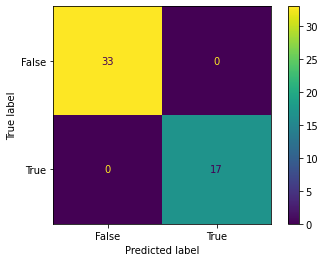

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()